In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.modeling.models import BlackBody

from astroquery.gaia import Gaia

from specutils import Spectrum1D
import speclite.filters
from scipy.optimize import curve_fit, Bounds

pd.set_option('display.max_columns', None)

In [2]:
dist_max = 1000
temp_min = 2000
temp_max = 10000

query = f"SELECT TOP 100 * FROM gaiadr3.gaia_source \
    JOIN gaiadr3.astrophysical_parameters AS ap USING (source_id) \
    WHERE ap.distance_gspphot <= {dist_max} AND \
    ap.teff_gspphot >= {temp_min} AND ap.teff_gspphot <= {temp_max} AND \
    ruwe <1.4 AND parallax_over_error >10 AND has_xp_sampled = 'True'"

In [3]:
job     = Gaia.launch_job_async(query)
results = job.get_results()
df_full = results.to_pandas()
df = df_full[['source_id', 'ra', 'dec', 'parallax', 'distance_gspphot', 'teff_gspphot', 'radius_gspphot', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'radial_velocity', 'logg_gspphot', 'mh_gspphot', ]].copy()
df['source_id'] = df['source_id'].astype(str)
df= df.dropna().reset_index(drop=True)
df.head(20)

INFO: Query finished. [astroquery.utils.tap.core]


,source_id,ra,dec,parallax,distance_gspphot,teff_gspphot,radius_gspphot,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,radial_velocity,logg_gspphot,mh_gspphot
0,5937144197726039936,251.458368,-50.771322,1.468394,618.920715,5139.183105,1.2766,14.039069,14.547703,13.368300,-22.728088,4.2553,-0.5361
1,5937081388118320256,251.623929,-51.624328,2.029256,448.400085,5688.343262,0.8769,13.948680,14.438930,13.287662,-28.915335,4.4441,-0.4156
2,5937201234877760256,250.585660,-51.279756,1.413660,693.021423,7027.607422,1.9635,12.191355,12.494401,11.719957,-12.043570,3.9771,-0.5277
3,5937201269237499648,250.596699,-51.277195,1.674957,585.583618,6128.315430,1.2421,13.256220,13.622023,12.703595,-14.648217,4.2704,-0.5492
4,5937173437846368768,250.190328,-51.596655,1.297819,681.628723,5672.112793,1.0095,14.384133,14.839954,13.761853,-34.589722,4.3661,-0.0853
5,5937112346245404672,251.215817,-51.101198,1.655215,615.253601,5033.540039,0.9855,14.597107,15.084415,13.936399,-18.697245,4.3757,-0.8174
6,5937144502576679296,251.438682,-50.738387,1.141473,835.127319,6122.689453,1.3074,13.935396,14.289813,13.359855,-28.685223,4.2340,-0.6855
7,5937144678762395392,251.507664,-50.732406,2.103157,488.259888,4728.604004,1.0288,14.693251,15.358689,13.893653,-6.666442,4.3255,-0.7524
8,5937144781841649280,251.498178,-50.704639,1.398661,674.482788,5432.183105,1.3455,13.900013,14.353931,13.268622,3.843210,4.2072,-0.9404
9,5937112685458529152,251.239729,-51.083520,1.853764,503.126404,5186.751953,0.7441,14.817905,15.350504,14.118507,2.478731,4.5616,-0.2343


In [4]:
# Select a Star
index = 0#df['distance_gspphot'].idxmin()
ra = df.loc[index, 'ra']
dec = df.loc[index, 'dec']
source_id = df.loc[index, 'source_id']
temp_eff = df.loc[index, 'teff_gspphot'] * u.K
phot_g_mean_mag = df.loc[index, 'phot_g_mean_mag']
phot_bp_mean_mag = df.loc[index, 'phot_bp_mean_mag']
phot_rp_mean_mag = df.loc[index, 'phot_rp_mean_mag']

print("RA: {}".format(ra))
print("dec: {}".format(dec))
print("temp_eff: {}".format(temp_eff))

RA: 251.45836750025484
dec: -50.77132195865252
temp_eff: 5139.18310546875 K


In [5]:
# Obtain the spectrum.
datalink = Gaia.load_data(source_id, data_structure = 'INDIVIDUAL', retrieval_type = 'XP_SAMPLED')
outputs = [datalink[key][0] for key in datalink.keys()]
table = outputs[0].to_table()
df_star_spectra = table.to_pandas()

# GAIA Units: Wavelength - nm; flux - W m-2 nm-1
# source
wavelength = (df_star_spectra['wavelength'].to_numpy()*u.nm)
flux = df_star_spectra['flux'].to_numpy()*u.W/u.m**2/u.nm

# Speclite code plays nicer with Angstroms and Erg S-1 cm-2 AA-1
flux_units = u.erg/u.s/u.cm**2/u.AA

wavelength = wavelength.to(u.AA)
flux = flux.to(flux_units)


In [6]:
# Find a Blackbody curve to approximate the spectrum.

# First define the planck function given temperature and wavelength
def planck_wavelength(wavelength, temperature, scale=1):
    wavelength = wavelength.to(u.m)
    numerator = 2*const.h*const.c**2/wavelength**5
    exponent = const.h*const.c/(wavelength*const.k_B*temperature)
    denominator = np.exp(exponent.value)-1
    
    return scale * (numerator/denominator).to(flux_units)

# Second define the curve fit function (adds units on input, removes on output)
def planck_wavelength_curvefit(wavelength, temperature, scale):
    wavelength *= u.AA
    temperature *= u.K
    return planck_wavelength(wavelength, temperature, scale).value

# Third define initial guess and bounds for temperature and scale
temp_guess = temp_eff.value if (temp_eff>0) else 5000
initial_guess = [temp_guess, 1e-17]  

# ideally should set lower bound of temp to be a low positive number, but this
# appears to shift the results in some cases.  Need to research.
bounds=((-np.inf, -np.inf), (np.inf, np.inf))

# Last perform the curve fit
# Fit the blackbody function to the observed data
params_opt, params_cov = curve_fit(planck_wavelength_curvefit, wavelength, flux, p0=initial_guess, bounds=bounds)

fitted_temperature, fitted_scale = params_opt
fitted_temperature *= u.K
print("Fitted Temperature:", fitted_temperature)
print("Fitted Amplitude:", fitted_scale)

flux_fitted = planck_wavelength(wavelength, fitted_temperature, fitted_scale)


# Alternate with Astropy BlackBody model
def blackbody_function (wavelength, temp, scale):
    wavelength = wavelength * u.AA
    bb = BlackBody(temperature=temp*u.K, scale=scale*flux_units/u.sr)
    return bb(wavelength).value

params_opt, params_cov = curve_fit(blackbody_function, wavelength, flux, p0=initial_guess, bounds=bounds)

bb_fitted_temperature, bb_fitted_scale = params_opt
bb_fitted_temperature *= u.K
print("Fitted Temperature:", bb_fitted_temperature)
print("Fitted Amplitude:", bb_fitted_scale)

bb = BlackBody(temperature=bb_fitted_temperature, scale=bb_fitted_scale*flux_units/u.sr)
bb_flux_fitted = bb(wavelength)


Fitted Temperature: 4726.495568004013 K
Fitted Amplitude: 7.210994647945775e-21
Fitted Temperature: 4726.49556850071 K
Fitted Amplitude: 7.21099464440777e-21


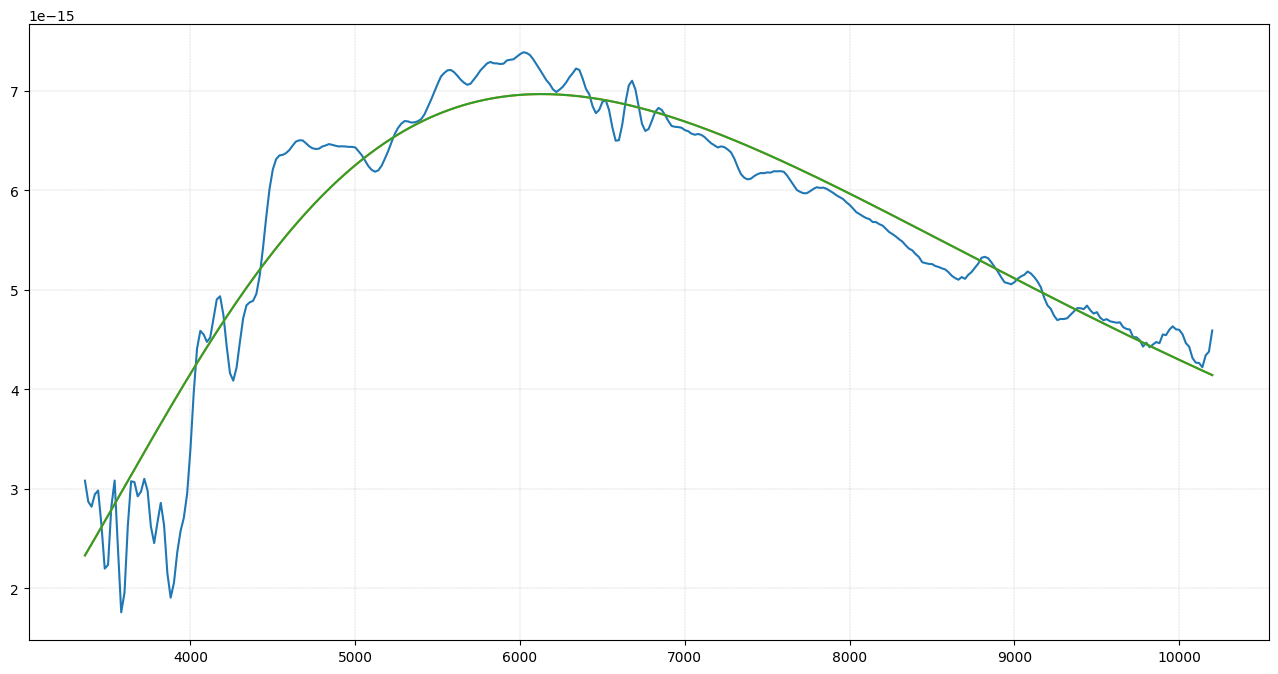

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.grid(color='grey', alpha=0.8, linestyle='-.', linewidth=0.2, axis='both') 
ax.plot(wavelength, flux)
ax.plot(wavelength, flux_fitted)
ax.plot(wavelength, bb_flux_fitted)


G: delta extended:-0.09985061905641501, delta fitted:-0.10360535165856888
BP: delta extended:-0.03659031391285872, delta fitted:-0.06397886794182206
RP: delta extended:-0.35760207524771026, delta fitted:-0.340755600725398


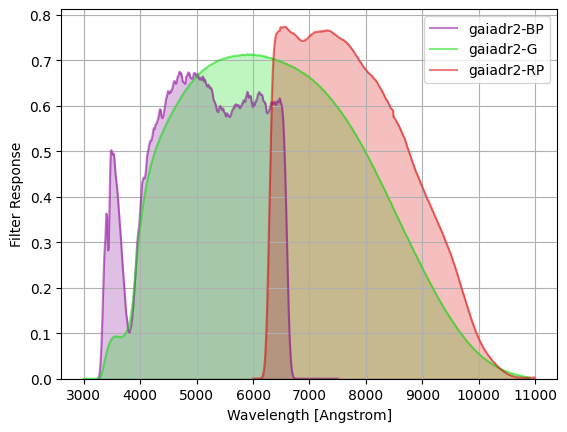

In [8]:
# Try computing apparent magnitudes with speclite filters and compare against GAIA values.
gaiadr2 = speclite.filters.load_filters('gaiadr2-*')
flux_extended, wavelength_extended = gaiadr2.pad_spectrum(flux, wavelength)
flux_fitted_extended = planck_wavelength(wavelength_extended, fitted_temperature, fitted_scale)

ab_magnitudes = gaiadr2.get_ab_magnitudes(flux_extended, wavelength_extended)
fitted_ab_magnitudes = gaiadr2.get_ab_magnitudes(flux_fitted_extended, wavelength_extended)

apparent_magnitude_g = ab_magnitudes['gaiadr2-G'][0]
apparent_magnitude_bp = ab_magnitudes['gaiadr2-BP'][0]
apparent_magnitude_rp = ab_magnitudes['gaiadr2-RP'][0]

fitted_apparent_magnitude_g = fitted_ab_magnitudes['gaiadr2-G'][0]
fitted_apparent_magnitude_bp = fitted_ab_magnitudes['gaiadr2-BP'][0]
fitted_apparent_magnitude_rp = fitted_ab_magnitudes['gaiadr2-RP'][0]

print("G: delta extended:{}, delta fitted:{}".format(phot_g_mean_mag-apparent_magnitude_g, phot_g_mean_mag-fitted_apparent_magnitude_g))
print("BP: delta extended:{}, delta fitted:{}".format(phot_bp_mean_mag-apparent_magnitude_bp, phot_bp_mean_mag-fitted_apparent_magnitude_bp))
print("RP: delta extended:{}, delta fitted:{}".format(phot_rp_mean_mag-apparent_magnitude_rp, phot_rp_mean_mag-fitted_apparent_magnitude_rp))

speclite.filters.plot_filters(gaiadr2)

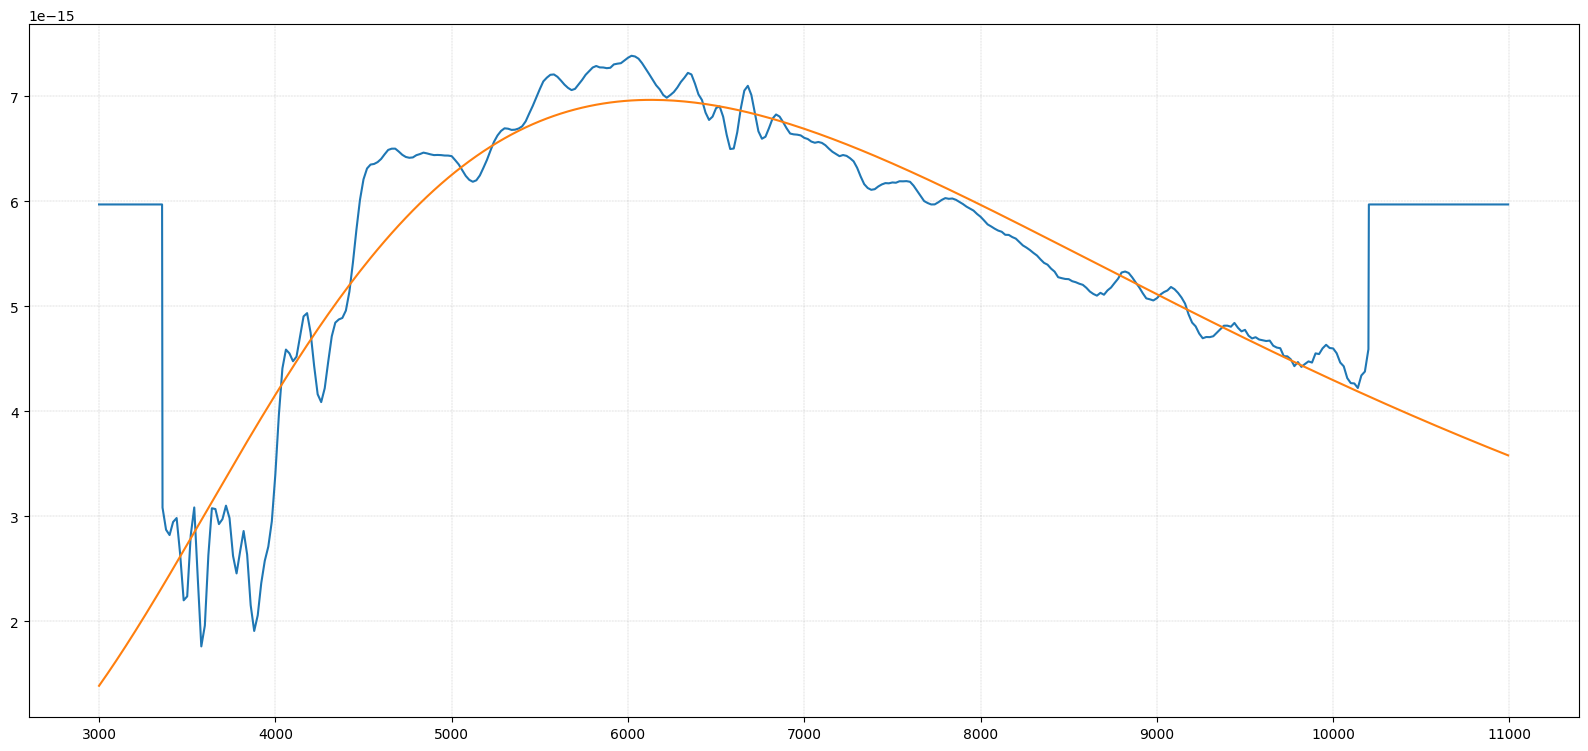

In [9]:
fig, ax = plt.subplots(figsize=(20, 9))
ax.grid(color='grey', alpha=0.8, linestyle='-.', linewidth=0.2, axis='both') 
ax.plot(wavelength_extended, flux_extended)
ax.plot(wavelength_extended, flux_fitted_extended)